Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and Hyperopt for hyperparameter tuning.

**Note:**
- All data
- registered_only = True

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/Imbalance/Churn_Imbalance_XGB_All_Hyperopt_SHAP_Tom")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 1, 1)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = True
mlflow.log_param("Setup complete", registered_only)

# whether to include following fields
no_duration = True
mlflow.log_param("no_duration", no_duration)

no_tier = True
mlflow.log_param("no_tier", no_tier)

no_license = True
mlflow.log_param("no_license", no_license)

2021/02/02 17:41:43 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
 - be included in your $PATH
 - be set via $GIT_PYTHON_GIT_EXECUTABLE
 - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
 - quiet|q|silence|s|none|n|0: for no warning or exception
 - warn|w|warning|1: for a printed warning
 - error|e|raise|r|2: for a raised exception

Example:
 export GIT_PYTHON_REFRESH=quiet

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe_2

In [0]:
df['InstanceId'].value_counts()

Out[24]: 50 3291
53 824
Name: InstanceId, dtype: int64

In [0]:
mlflow.log_param("Instances", df['InstanceId'].value_counts())

all companies with licenses: 13417

More filtering before modeling

In [0]:
# all available features
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]
# numerical_features = ["StandaloneLicenses", "AddonLicenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

if registered_only:
  categorical_features = ["Tier", "UserIntegrationType"]

if no_tier:
  categorical_features = ["UserIntegrationType"]
  
if no_duration == True and no_license == False:
  numerical_features = ["StandaloneLicenses", "AddonLicenses", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]
  
if no_duration == False and no_license == True:
  numerical_features = ["Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

if no_duration == True and no_license == True:
  numerical_features = ["Incidents", "Trips", "Forms", "Timekeeping", "Orders"]
    

Categorical feature distributions

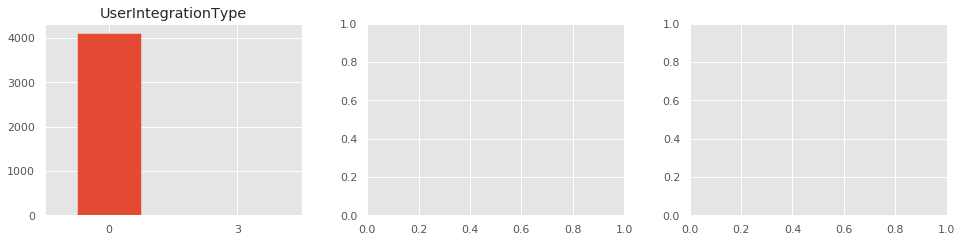

In [0]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

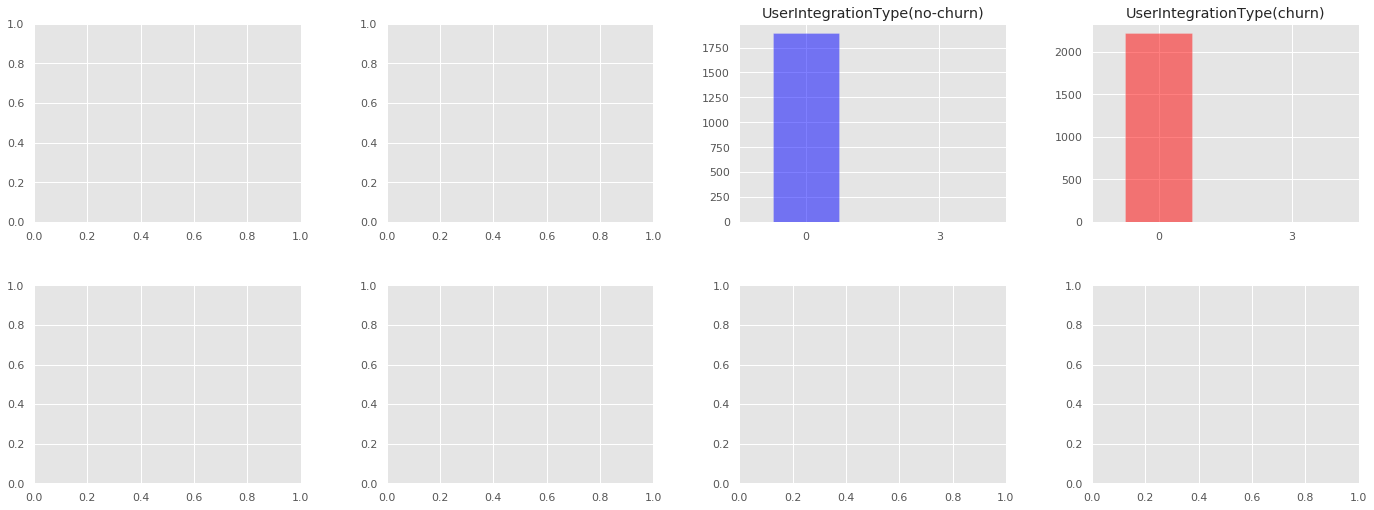

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

if no_tier == False:
   df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('Tier(no-churn)')
   df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('UserIntegrationType(churn)')

if registered_only == False:
  df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('IsSetupComplete(no-churn)')
  df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('IsSetupComplete(churn)')
  
fig.tight_layout(pad=4.0)


Numerical feature distributions

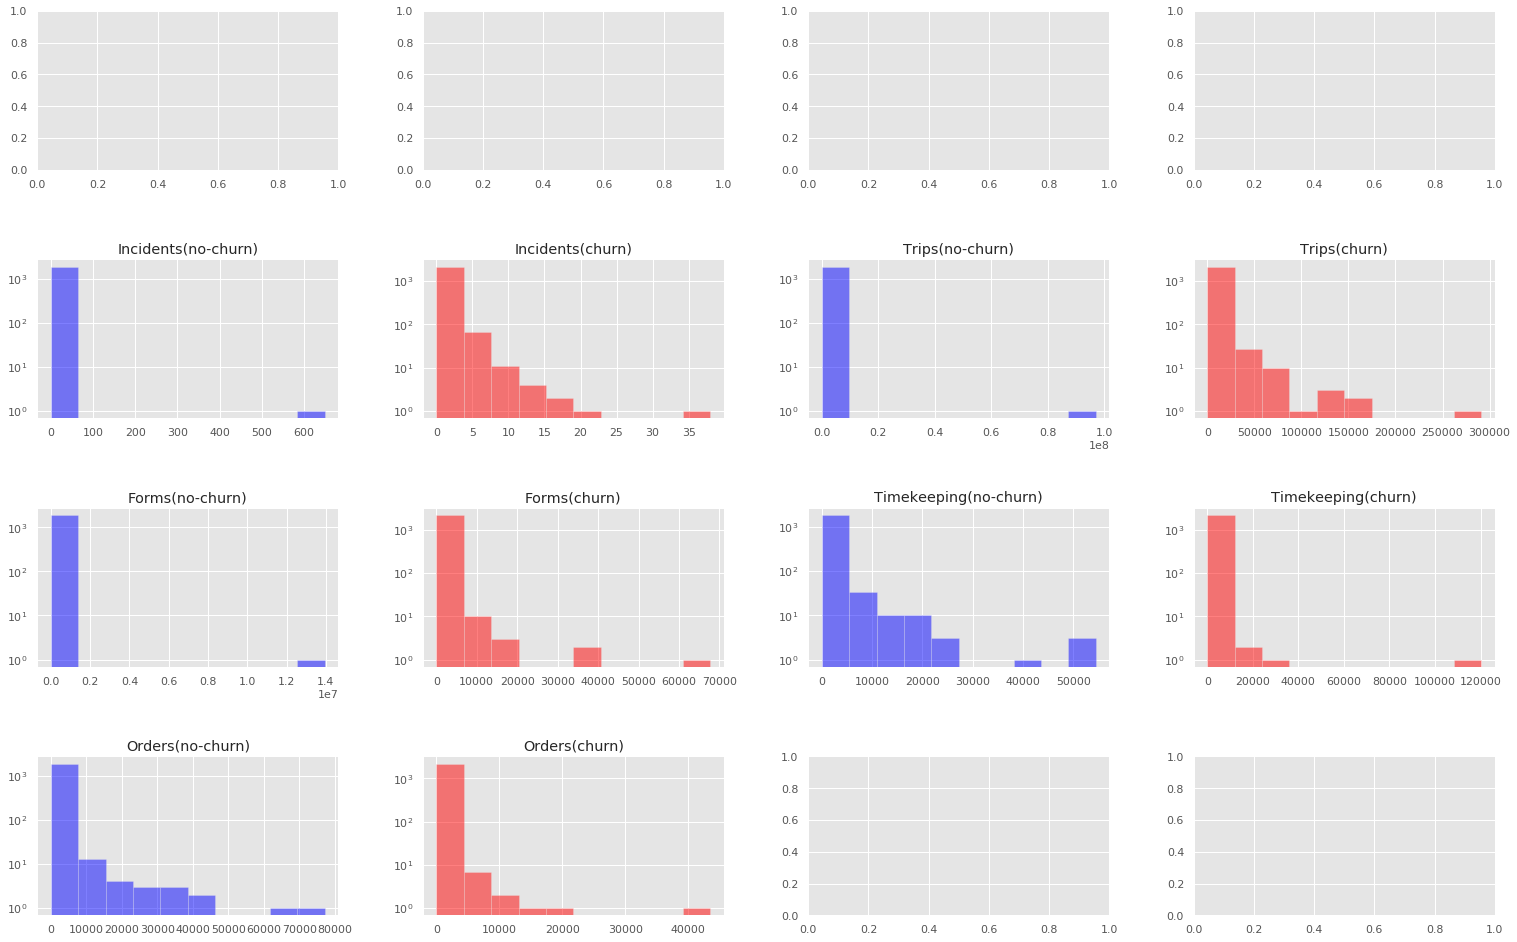

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

if no_license == False:
   df[df.Churn == False]["StandaloneLicenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("StandaloneLicenses(no-churn)")
   df[df.Churn == True]["StandaloneLicenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("StandaloneLicenses(churn)")
   ax[0, 0].set_yscale('log')
   ax[0, 1].set_yscale('log')

if no_duration == False:
   df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
   df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

if no_license == False:
   df[df.Churn == False]["AddonLicenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("AddonLicenses(no-churn)")
   df[df.Churn == True]["AddonLicenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("AddonLicenses(churn)")
   ax[3, 2].set_yscale('log')
   ax[3, 3].set_yscale('log')

fig.tight_layout(pad=4.0)

In [0]:
#***** FOR test only ******
df_test = df[df['Deactivation'].isnull()]
df_test_input = df_test[categorical_features + numerical_features]
df_test_input.shape

Out[30]: (1377, 6)

Correlation Matrix and Heatmap

In [0]:
df_final = df[categorical_features + [target] + numerical_features]

df_final.corr()

Out[31]:

,UserIntegrationType,Churn,Incidents,Trips,Forms,Timekeeping,Orders
UserIntegrationType,1.000000,-0.001747,-0.002669,-0.000486,-0.000441,-0.002973,-0.002351
Churn,-0.001747,1.000000,-0.074343,-0.021740,-0.020563,-0.071173,-0.077070
Incidents,-0.002669,-0.074343,1.000000,0.967466,0.966899,0.037389,0.038890
Trips,-0.000486,-0.021740,0.967466,1.000000,0.998993,0.008473,0.001485
Forms,-0.000441,-0.020563,0.966899,0.998993,1.000000,0.009316,0.001918
Timekeeping,-0.002973,-0.071173,0.037389,0.008473,0.009316,1.000000,0.108038
Orders,-0.002351,-0.077070,0.038890,0.001485,0.001918,0.108038,1.000000


Out[32]:

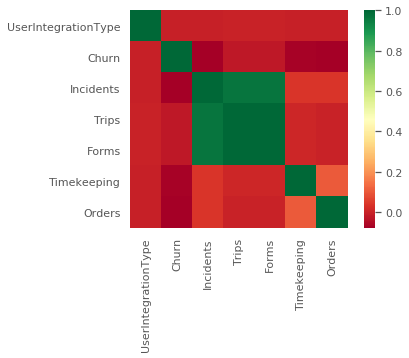

<matplotlib.axes._subplots.AxesSubplot at 0x7f76c78a37d0>

In [0]:
sns.heatmap(df_final.corr(), square=True, cmap='RdYlGn')

In [0]:
df_final.describe(include='all')

Out[33]:

,UserIntegrationType,Churn,Incidents,Trips,Forms,Timekeeping,Orders
count,4115.000000,4115.000000,4115.000000,4.115000e+03,4.115000e+03,4115.000000,4115.000000
mean,0.001458,0.539490,1.265128,3.330552e+04,4.346792e+03,401.834265,272.374727
std,0.066130,0.498499,10.452194,1.511847e+06,2.175977e+05,2980.390953,2554.567321
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.650000e+02,0.000000e+00,0.000000,0.000000
75%,0.000000,1.000000,1.000000,5.271500e+03,4.000000e+00,5.000000,0.000000
max,3.000000,1.000000,649.000000,9.692331e+07,1.394516e+07,120322.000000,77193.000000


Create dummy variables for categorical variables

In [0]:
# cat_vars=['IsSetupComplete','Tier','UserIntegrationType']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1
    
# df_vars=df.columns.values.tolist()
# to_keep=[i for i in df_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

In [0]:
df_final.head()

Out[35]:

,UserIntegrationType,Churn,Incidents,Trips,Forms,Timekeeping,Orders
0,0,0,0,2819,0,66,0
1,0,0,0,0,5,4,521
2,0,0,7,16293,1,0,0
3,0,1,0,922,0,0,0
4,0,1,0,16683,2,0,6


In [0]:
mlflow.log_param("dataset shape", df_final.shape)

**Training**

In [0]:
# --- training with SMOTE ---
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# we can Check the numbers of our data
print("length of data is ",len(X_train))
print("Number of no churn in  data",len(y_train[y_train['Churn']==0]))
print("Number of churn",len(y_train[y_train['Churn']==1]))
print("Proportion of no churn data in data is ",len(y_train[y_train['Churn']==0])/len(X_train))
print("Proportion of churn data in data is ",len(y_train[y_train['Churn']==1])/len(X_train))


length of data is 3086
Number of no churn in data 1410
Number of churn 1676
Proportion of no churn data in data is 0.45690213869086194
Proportion of churn data in data is 0.5430978613091381

In [0]:
# training the model
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
  
# define space
space = {
    # complexity
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.5, 2),
    "gamma": hp.uniform("gamma", 1, 9),
    "n_estimators": hp.quniform("n_estimators", 100, 150, 1), # default 100
    # noise
    "learning_rate": hp.uniform("learning_rate", 0.03, 0.2), # default 0.1    
    "subsample": hp.uniform("subsample", 0.6, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1),
    # imbalance
    "scale_pos_weight": hp.uniform("scale_pos_weight", 0.3, 2)
}

# define objective func
def hyperparameter_tuning(space):
    model = XGBClassifier(n_estimators = int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          min_child_weight = space['min_child_weight'],
                          gamma = space['gamma'],
                          learning_rate = space['learning_rate'],
                          subsample = space['subsample'],
                          colsample_bytree = space['colsample_bytree'],
                          scale_pos_weight = space['scale_pos_weight'],
                          random_state = 42)
    
    evaluation = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
    
    model.fit(X_train, np.ravel(y_train),
            eval_set=evaluation, eval_metric="auc", #error, (default)
            early_stopping_rounds=10,verbose=False)

#     accuracies = cross_val_score(estimator = model, X = X_train, y = np.ravel(y_train), cv = 5, scoring=scoring)
#     accuracy = accuracies.mean()
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#     accuracy = roc_auc_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': 1-accuracy, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=np.random.RandomState(42))

print (best)

/databricks/python/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 from imp import reload
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] SCORE:
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] 0.6763848396501457
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] 0%| | 1/200 [00:00<01:20, 2.48trial/s, best loss: 0.32361516034985427] SCORE:
 0%| | 1/200 [00:00<01:20, 2.48trial/s, best loss: 0.32361516034985427] 0.6812439261418853
 0%| | 1/200 [00:00<01:20, 2.48trial/s, best loss: 0.32361516034985427] 1%| | 2/200 [00:00<01:03, 3.10trial/s, best loss: 0.31875607385811466] SCORE:
 1%| | 2/200 [00:00<01:03, 3.10trial/s, best loss: 0.31875607385811466] 0.6569484936831875
 1%| | 2/200 [00:00<01:03, 3.10trial/s, best loss: 0.31875607385811466] 2%|▏ | 3/200 [00:00<00:50, 3.90trial/s, best loss: 0.31875607385811466] SCORE:
 2%|▏ | 3/200 [00:00<00:50, 3.90trial/s, best loss: 0.31875607385811466] 0.6647230320699709
 2%|▏ | 3/200 [00:00<00:50, 3.90trial/s, best loss: 0.31875607385811466] SCORE:
 2%|▏ | 4/200 [00:00<00:50, 3.90trial/s, best loss: 0.31875607385811466] 0.7016520894071915
 2%|▏ | 4/200 [00:00<00:50, 3.90trial/s, best loss: 0.31875607385811466] 2%|▎ | 5/200 [00:00<00:38, 5.11trial/s, best loss: 0.2983479105928085]  SCORE:
 2%|▎ | 5/200 [00:00<00:38, 5.11trial/s, best loss: 0.2983479105928085] 0.6997084548104956
 2%|▎ | 5/200 [00:00<00:38, 5.11trial/s, best loss: 0.2983479105928085] 3%|▎ | 6/200 [00:00<00:34, 5.56trial/s, best loss: 0.2983479105928085] SCORE:
 3%|▎ | 6/200 [00:00<00:34, 5.56trial/s, best loss: 0.2983479105928085] 0.6647230320699709
 3%|▎ | 6/200 [00:00<00:34, 5.56trial/s, best loss: 0.2983479105928085] SCORE:
 4%|▎ | 7/200 [00:01<00:34, 5.56trial/s, best loss: 0.2983479105928085] 0.6773566569484937
 4%|▎ | 7/200 [00:01<00:34, 5.56trial/s, best loss: 0.2983479105928085] 4%|▍ | 8/200 [00:01<00:29, 6.53trial/s, best loss: 0.2983479105928085] SCORE:
 4%|▍ | 8/200 [00:01<00:29, 6.53trial/s, best loss: 0.2983479105928085] 0.6540330417881438
 4%|▍ | 8/200 [00:01<00:29, 6.53trial/s, best loss: 0.2983479105928085] SCORE:
 4%|▍ | 9/200 [00:01<00:29, 6.53trial/s, best loss: 0.2983479105928085] 0.6754130223517979
 4%|▍ | 9/200 [00:01<00:29, 6.53trial/s, best loss: 0.2983479105928085] 5%|▌ | 10/200 [00:01<00:24, 7.70trial/s, best loss: 0.2983479105928085] SCORE:
 5%|▌ | 10/200 [00:01<00:24, 7.70trial/s, best loss: 0.2983479105928085] 0.673469387755102
 5%|▌ | 10/200 [00:01<00:24, 7.70trial/s, best loss: 0.2983479105928085] SCORE:
 6%|▌ | 11/200 [00:01<00:24, 7.70trial/s, best loss: 0.2983479105928085] 0.7016520894071915
 6%|▌ | 11/200 [00:01<00:24, 7.70trial/s, best loss: 0.2983479105928085] 6%|▌ | 12/200 [00:01<00:21, 8.84trial/s, best loss: 0.2983479105928085] SCORE:
 6%|▌ | 12/200 [00:01<00:21, 8.84trial/s, best loss: 0.2983479105928085] 0.7026239067055393
 6%|▌ | 12/200 [00:01<00:21, 8.84trial/s, best loss: 0.2983479105928085] SCORE:
 6%|▋ | 13/200 [00:01<00:21, 8.84trial/s, best loss: 0.2973760932944607] 0.5451895043731778
 6%|▋ | 13/200 [00:01<00:21, 8.84trial/s, best loss: 0.2973760932944607] 7%|▋ | 14/200 [00:01<00:17, 10.58trial/s, best loss: 0.2973760932944607] SCORE:
 7%|▋ | 14/200 [00:01<00:17, 10.58trial/s, best loss: 0.2973760932944607] 0.6627793974732751
 7%|▋ | 14/200 [00:01<00:17, 10.58trial/s, best loss: 0.2973760932944607] SCORE:
 8%|▊ | 15/200 [00:01<00:17, 10.58trial/s, best loss: 0.2973760932944607] 0.6715257531584062
 8%|▊ | 15/200 [00:01<00:17, 10.58trial/s, best loss: 0.2973760932944607] 8%|▊ | 16/200 [00:01<00:15, 11.78trial/s, best loss: 0.2973760932944607] SCORE:
 8%|▊ | 16/200 [00:01<00:15, 11.78trial/s, best loss: 0.2973760932944607] 0.673469387755102
 8%|▊ | 16/200 [00:01<00:15, 11.78trial/s, best loss: 0.2973760932944607] SCORE:
 8%|▊ | 17/200 [00:01<00:15, 11

Use best model to get all metrics

In [0]:
# clf = XGBClassifier(random_state=42)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# mlflow.log_param("RepeatedStratifiedKFold", cv)

# # ****** GridSearchCV *************
# param_grid = {
#     # complexity
#     "max_depth": [int(best["max_depth"])],
#     "min_child_weight": [best["min_child_weight"]],
#     "gamma":  [best["gamma"]],
#     "n_estimators":  [int(best["n_estimators"])],
#     # noise
#     "learning_rate":  [best["learning_rate"]],   
#     "subsample":  [best["subsample"]],
#     "colsample_bytree":  [best["colsample_bytree"]],
#     # imbalance
#     "scale_pos_weight":  [best["scale_pos_weight"]]
# }

# tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring)
# # tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
# tree_cv.fit(X_train, np.ravel(y_train))
# pred = tree_cv.predict(X_test)

# print("Tuned XGBoost: {}".format(tree_cv.best_params_))
# print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# # Log mlflow attributes for mlflow UI
# mlflow.log_param("hyperparameters", tree_cv.best_params_)
# mlflow.sklearn.log_model(tree_cv, "model")
# mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))

In [0]:
best_params = {
    # complexity
    "max_depth": int(best["max_depth"]),
    "min_child_weight": best["min_child_weight"],
    "gamma": best["gamma"],
    "n_estimators": int(best["n_estimators"]),
    # noise
    "learning_rate": best["learning_rate"],   
    "subsample": best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    # imbalance
    "scale_pos_weight": best["scale_pos_weight"],
    "random_state": 42
}

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, np.ravel(y_train))
pred = best_model.predict(X_test)

print("Tuned XGBoost: {}".format(best_params))
accuracy = accuracy_score(y_test, pred>0.5)
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(accuracy))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", best_params)
mlflow.log_metric("accuracy", accuracy)

Tuned XGBoost: {'max_depth': 7, 'min_child_weight': 1.1349004765956154, 'gamma': 7.493861931144563, 'n_estimators': 124, 'learning_rate': 0.09408336193859271, 'subsample': 0.8296975490917639, 'colsample_bytree': 0.9480081013914842, 'scale_pos_weight': 0.7920284751197927, 'random_state': 42}
Accuracy of XGBoost classifier on test set: 0.70

In [0]:
# **** FOR TEST only*****
pred_test = best_model.predict(df_test_input)

condition = (pred_test == 0)
noChurn = np.extract(condition, pred_test) 

condition = (pred_test == 1)
churn = np.extract(condition, pred_test) 
print('churn data is ', len(churn))
print('proporation of churn data ', len(churn)/len(pred_test))

churn data is 430
proporation of churn data 0.31227305737109656

Log the model to the registry for deployment

In [0]:
# sklearn model wrapper
class ModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

wrappedModel = ModelWrapper(best_model)
mlflow.pyfunc.log_model("XGBClassifier_model", python_model=wrappedModel)

**Testing **

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

# print(classification_report(y_test, pred, labels=np.unique(pred), zero_division=0))
print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.71 0.62 0.66 485
 1 0.70 0.78 0.73 544

 accuracy 0.70 1029
 macro avg 0.70 0.70 0.70 1029
weighted avg 0.70 0.70 0.70 1029

In [0]:
condition = (pred == 0)
noChurn = np.extract(condition, pred) 
print('no churn data is ', len(noChurn))

condition = (pred == 1)
churn = np.extract(condition, pred) 
print('churn data is ', len(churn))
print('proporation of churn data ', len(churn)/len(pred))

no churn data is 421
churn data is 608
proporation of churn data 0.5908649173955296

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

**Model Interpretation**

In [0]:
model = best_model
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.9480081013914842,
 gamma=7.493861931144563, gpu_id=-1, importance_type='gain',
 interaction_constraints='', learning_rate=0.09408336193859271,
 max_delta_step=0, max_depth=7,
 min_child_weight=1.1349004765956154, missing=nan,
 monotone_constraints='()', n_estimators=124, n_jobs=0,
 num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
 scale_pos_weight=0.7920284751197927, subsample=0.8296975490917639,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['UserIntegrationType', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

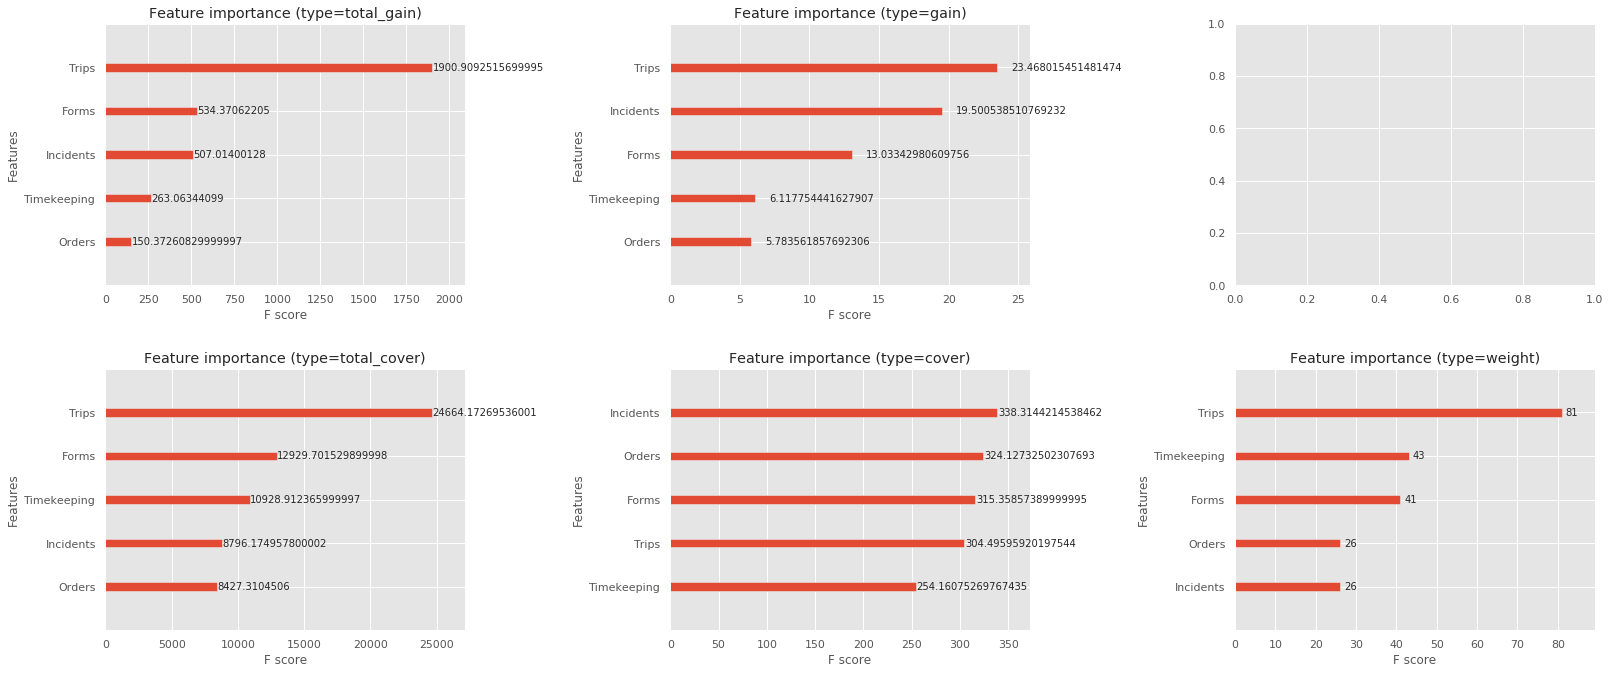

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

ROC Curve for test data

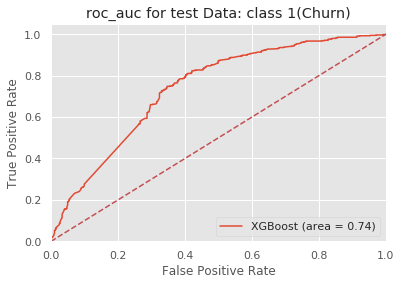

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

tree_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 test data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for test Data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()


ROC Curve for train data

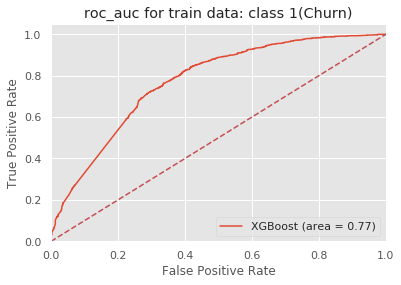

In [0]:
tree_roc_auc = roc_auc_score(y_train, best_model.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 train data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for train data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

roc_auc for traning data is 0.85, and 0.81 for test data. It is the decent fit.

In [0]:
mlflow.end_run()